In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import os
import pickle
import jax
from typing import Optional, Tuple, Callable
from chex import PRNGKey
from src.environments.Domain.DiscreteDomain import DiscreteDomain
from src.environments.Domain import domain_feature_generator
from src.environments.DuelingEnvironment.UtilityDuellingEnvironment import (
    UtilityDuellingEnv,
    UtilityDuellingParams,
)
from Preference_Embeddings.JAXEmbeddings import ComplexPreference
import flax.serialization as serialization
import json
import matplotlib.patches as patches
from src.environments.DuelingEnvironment.GPODuellingEnvironment import GPODuellingEnv
from Stackelberg.src.utils.utility_functions import ackley, branin, eggholder, hoelder, matyas, michalewicz, rosenbrock, bukin
from collections import namedtuple

In [2]:
AffineTransform = namedtuple("AffineTransform", ["affine_transform"])
affine_transform = AffineTransform(jnp.array([1.,0.]))
minima = {
    "ackley": [[0,0]],#
    "branin": [[-jnp.pi,12.275],[jnp.pi, 2.275],[9.42478,2.475]], #This one has 3 minima
    "eggholder": [[512,404.2319]],
    "hoelder":[[ 8.05502,  9.66459],
               [ 8.05502, -9.66459],
               [-8.05502,  9.66459],
               [-8.05502, -9.66459],], #This one has 4?
    "matyas": [[0,0]],#
    "michalewicz": [[2.2,1.57]],#
    "rosenbrock": [[1,1]],#
    "bukin": [[-10,1]]
}

In [3]:
# --- 2. Create the Matplotlib Plot ---
def plot_jax_grid(score_data, best_point_idx, vmin=None):
    """
    Plots a 2D JAX score grid with a specified best point highlighted in red.

    Args:
        score_data (jax.numpy.ndarray): A 2D JAX array containing the scores for each point.
        best_point_idx (jax.numpy.ndarray): A 1D JAX array with two elements [row, col]
                                            indicating the index of the best point.
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    # Display the score grid using imshow.
    # 'cmap' sets the colormap (e.g., 'viridis', 'plasma', 'cividis', 'RdYlGn').
    # 'origin='lower'' ensures that the [0,0] index is at the bottom-left,
    # which often aligns better with mathematical coordinate systems.
    # If your data is indexed like a matrix (row 0 at top), use 'origin='upper''.
    # 'interpolation='nearest'' ensures sharp, distinct squares rather than blurring.
    im = ax.imshow(score_data, cmap='viridis', origin='lower', interpolation='nearest', vmin=vmin)

    # Add a color bar to show the mapping of scores to colors
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75)
    cbar.set_label('Score', fontsize=12)

    # Highlight the best point with a red square
    # Get the row and column from the best_point_idx
    row, col = best_point_idx[0], best_point_idx[1]

    # Create a rectangle patch.
    # The (x, y) coordinates for the lower-left corner of the patch.
    # For imshow with origin='lower' and interpolation='nearest',
    # a cell at (col, row) has its lower-left corner effectively at (col-0.5, row-0.5)
    # if you think of it as continuous coordinates.
    # A width and height of 1 covers exactly one cell.
    rect = patches.Rectangle((col - 0.5, row - 0.5), 1, 1,
                             linewidth=3, edgecolor='red', facecolor='none')

    # Add the rectangle to the Axes
    ax.add_patch(rect)

    # Set titles and labels
    ax.set_title('Grid Score Visualization with Best Point Highlighted', fontsize=14)
    ax.set_xlabel('Column Index', fontsize=12)
    ax.set_ylabel('Row Index', fontsize=12)

    # Set ticks to be at the center of the squares for better alignment
    ax.set_xticks(jnp.arange(score_data.shape[1]))
    ax.set_yticks(jnp.arange(score_data.shape[0]))

    # Ensure the plot fits tightly
    plt.tight_layout()
    plt.show()


In [4]:
def get_model(name: str) -> Callable:
    # -----------------------------------------------------------------------------
    # 2.2) Read hyperparameters from JSON
    # -----------------------------------------------------------------------------
    hparam_path = f"../Embedding_Model_Weights/{name}.json"
    with open(hparam_path, "r") as f:
        metadata = json.load(f)
    hparams = metadata["hparams"]
    in_dim = hparams["in_dim"]
    factor = hparams["factor"]
    sizes  = hparams["sizes"]  # e.g. [128, 64]

    # Re‐instantiate the Flax model with these hyperparameters
    model_def = ComplexPreference(in_dim=in_dim, factor=factor, sizes=sizes)

    # -----------------------------------------------------------------------------
    # 2.3) Build a dummy “params” PyTree to use as a template
    # -----------------------------------------------------------------------------
    # ANY batch_size ≥ 1 will do; we only need correct shapes.
    rng = jax.random.PRNGKey(0)
    dummy_x  = jnp.zeros((1, in_dim), dtype=jnp.float32)
    dummy_xp = jnp.zeros((1, in_dim), dtype=jnp.float32)

    variables    = model_def.init(rng, dummy_x, dummy_xp)
    dummy_params = variables["params"]  # a FrozenDict tree matching the saved structure

    # -----------------------------------------------------------------------------
    # 2.4) Read the saved parameter bytes and re‐hydrate them
    # -----------------------------------------------------------------------------
    param_path = f"../Embedding_Model_Weights/{name}.msgpack"
    with open(param_path, "rb") as f:
        loaded_bytes = f.read()

    restored_params = serialization.from_bytes(dummy_params, loaded_bytes)
    return lambda x, y: model_def.apply({"params": restored_params}, x, y)

In [5]:
#Copying function as I can't really import it from a module
def initialize_domain(
        rng: PRNGKey, config: dict, env_data: Optional[dict] = None, gpo: bool = False
) -> Tuple[DiscreteDomain, UtilityDuellingEnv, UtilityDuellingParams]:
    # Setup domain and environment
    if config["utility_function"] != "yelp":
        rng, _rng = jax.random.split(rng)
        if config["domain"]["initialization"] == "normal":
            arm_features = domain_feature_generator.normal(_rng, config)
        elif config["domain"]["initialization"] == "uniform":
            arm_features = domain_feature_generator.uniform(_rng, config)
        elif config["domain"]["initialization"] == "meshgrid":
            arm_features = domain_feature_generator.meshgrid(
                _rng,
                jnp.array(config["domain"]["params"]["range"]),
                int(config["num_arms"] ** (1 / config["feature_dim"])),
                config["feature_dim"],
            )
        else:
            raise ValueError("Invalid arm_initialization. Use 'normal' or 'uniform'.")
        domain = DiscreteDomain.create(
            num_elements=config["num_arms"], features=arm_features
        )
    elif config["utility_function"] == "yelp":
        arm_features, utilities = env_data["arm_features"], env_data["utilities"]
        domain = DiscreteDomain.create(
            num_elements=arm_features.shape[0], features=arm_features
        )
    else:
        raise ValueError("Invalid param_initialization. Use 'normal' or 'yelp'.")

    # print("Best arm: ", best_arm, "Best arm utility: ", best_arm_utility)
    return domain

In [6]:
func_name = "matyas"
input_dir = f"data/preference_feedback/{func_name}"
file_end = "_gpo"

# Load the data
for result_file in os.listdir(input_dir):
    gpo_check = result_file.endswith("_gpo.pkl")
    if result_file.endswith(".pkl") and not result_file.endswith("estimator_params.pkl") and not result_file.endswith("grid_search_params.pkl") and gpo_check:
        print("Result path: ", result_file)
        algo_name = result_file.split(".")[0]
        with open(input_dir + "/" + result_file, "rb") as f:
            data = pickle.load(f)

Result path:  max_min_lcb_no_candidates_gpo.pkl


In [7]:
#Load the config
with open(os.path.join(input_dir, "config.yaml"), "r") as f:
    config = yaml.safe_load(f)

In [8]:
#setting up environment to read data
rng = jax.random.PRNGKey(config["seed"])
domain = initialize_domain(rng, config)
X, Xp = data["selected_arm"]
X_arms, Xp_arms = list(), list()
for x_arm_idx, xp_arm_idx in zip(X, Xp):
    for leader_idx, follower_idx in zip(x_arm_idx, xp_arm_idx):
        #first makes sure the index is in range, then gets the feature from the domain
        x_arm_data = domain.project(leader_idx)
        x_arm_data = domain.get_feature(leader_idx)
        xp_arm_data = domain.project(follower_idx)
        xp_arm_data = domain.get_feature(xp_arm_data)
        X_arms.append(x_arm_data)
        Xp_arms.append(xp_arm_data)
X_arms = jnp.array(Xp_arms)
Xp_arms = jnp.array(Xp_arms)

Text(0.5, 0.98, 'matyas Samples and Maxima')

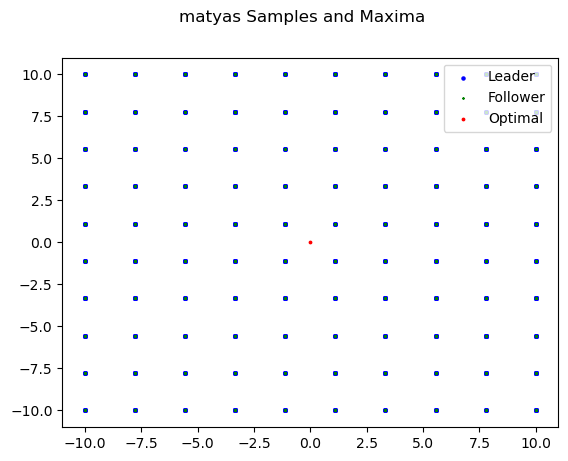

In [9]:
X, Xp = data["real_arms"]
X_arms = X.reshape(-1, 2)
Xp_arms = Xp.reshape(-1, 2)
fig, ax = plt.subplots()
s=1
ax.scatter(X_arms[:,0], X_arms[:,1], c="blue", label="Leader", s=5*s)
ax.scatter(Xp_arms[:,0], Xp_arms[:,1], c="green", label="Follower", s=s, marker="*")
optimal_points = jnp.array(minima[func_name])
ax.scatter(optimal_points[:,0], optimal_points[:,1], c="red", label="Optimal", s=3*s)
ax.legend(loc="upper right")
fig.suptitle(f"{func_name} Samples and Maxima")

In [10]:
model = get_model(func_name)

In [11]:
bounds = config["domain"]["params"]["range"]
x_vals = jnp.linspace(bounds[0][0], bounds[0][1], 100)
y_vals = jnp.linspace(bounds[1][0], bounds[1][1], 100)

# Use np.meshgrid to create 2D coordinate arrays
# X and Y will have dimensions (100, 100)
X, Y = jnp.meshgrid(x_vals, y_vals)
points = jnp.stack([X,Y], axis=-1).reshape(-1, 2)

In [12]:
best_arm = domain.get_feature(data["best_arm"][0][0])
score_func = lambda x: model(best_arm, x)
scores = model(best_arm, points)
probs = jax.nn.sigmoid(scores)

Text(0.5, 0.92, 'Scores')

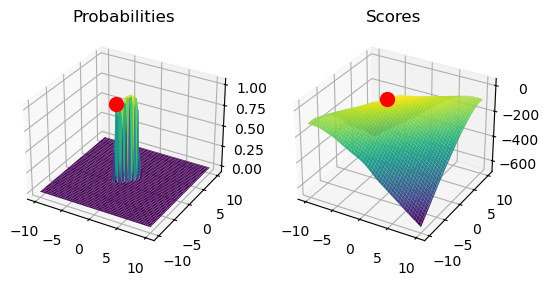

In [13]:
fig = plt.figure()
ax = fig.add_axes(121, projection="3d", computed_zorder=False)
ax.plot_surface(X, Y, probs.reshape(100, 100), cmap="viridis")
ax.scatter(best_arm[0], best_arm[1], jax.nn.sigmoid(model(best_arm, best_arm)), s=100, c="red")
ax.set_title("Probabilities")
ax2 = fig.add_axes(122, projection="3d", computed_zorder=False)
ax2.plot_surface(X, Y, scores.reshape(100,100), cmap="viridis")
ax2.scatter(best_arm[0], best_arm[1], model(best_arm, best_arm), s=100, c="red")
ax2.set_title("Scores")

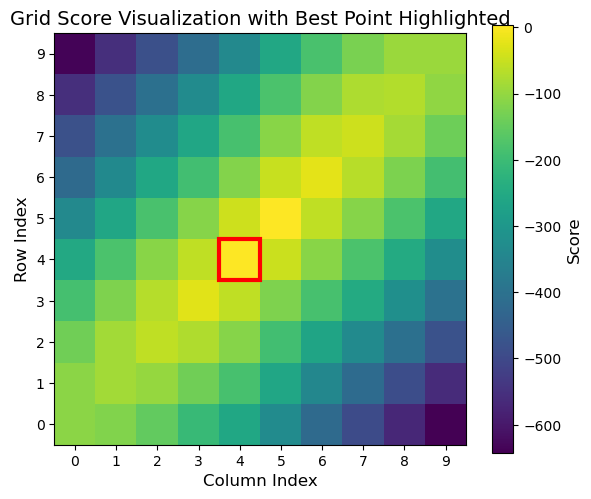

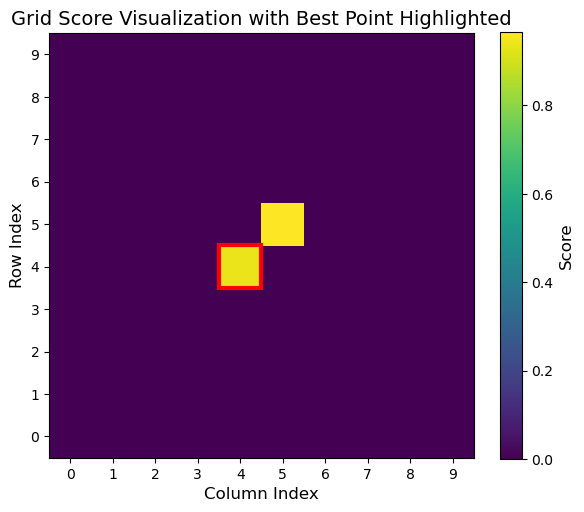

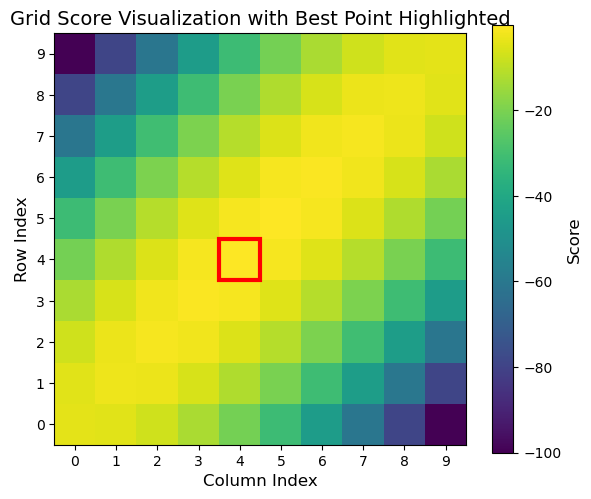

In [34]:
domain_points = jnp.array([domain.get_feature(i) for i in domain.indices])
best_point_idx = (4,4)#data["best_arm"][0][0] need to code later
test_arm = domain_points[best_point_idx[0]*10 + best_point_idx[1]]
scores = model(test_arm, domain_points).reshape(10,10)
true_vals = jnp.array([matyas(point, affine_transform) for point in domain_points]).reshape(10,10)
plot_jax_grid(scores, best_point_idx, vmin=None)
plot_jax_grid(jax.nn.sigmoid(scores), best_point_idx)
plot_jax_grid(true_vals, best_point_idx)

In [15]:
data["regrets"]

Array([[[0.320158  , 0.67588925],
        [0.1422925 , 0.08300376],
        [0.07114625, 0.770751  ],
        ...,
        [1.86166   , 0.367589  ],
        [0.320158  , 3.6403158 ],
        [2.667984  , 5.9999995 ]],

       [[1.2094862 , 0.71146226],
        [0.43873525, 0.77075076],
        [0.770751  , 0.770751  ],
        ...,
        [0.118577  , 0.        ],
        [1.1857708 , 0.71146226],
        [1.897233  , 0.08300376]],

       [[3.6284585 , 0.367589  ],
        [0.367589  , 5.9999995 ],
        [3.6403162 , 0.07114601],
        ...,
        [4.743083  , 0.1778655 ],
        [0.2608695 , 0.02371526],
        [4.7430825 , 1.2569166 ]],

       ...,

       [[5.9999995 , 0.67588925],
        [0.02371526, 3.6403162 ],
        [0.77075076, 0.1778655 ],
        ...,
        [0.770751  , 0.320158  ],
        [0.6640315 , 0.367589  ],
        [2.691699  , 5.9999995 ]],

       [[1.8498024 , 0.26086926],
        [3.6403158 , 0.6640315 ],
        [3.6403158 , 0.2608695 ],
        .

Text(0.5, 0.98, '% times that best is sampled')

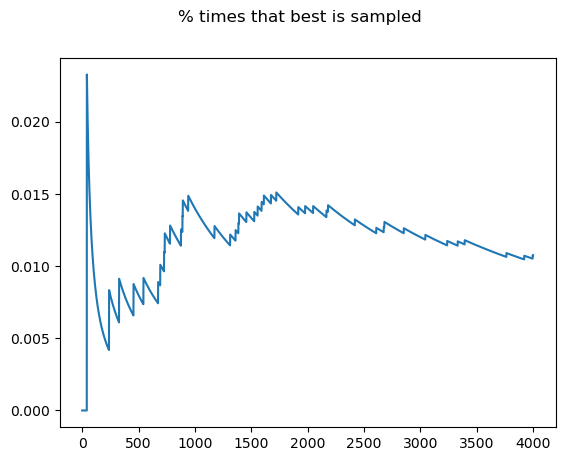

In [16]:
r = (data["selected_arm"][0] == 44).cumsum()
plt.plot(r/jnp.arange(1, len(r)+1))
plt.suptitle("% times that best is sampled")

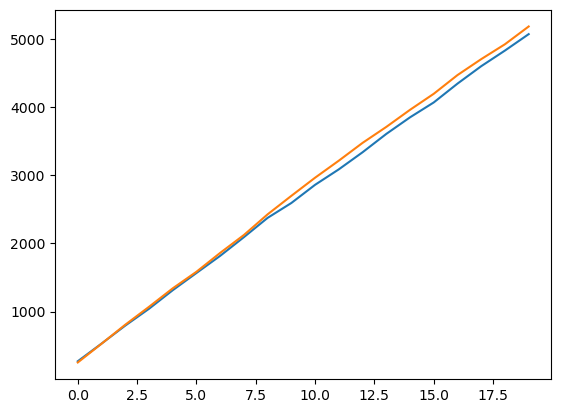

In [17]:
plt.plot(data["regrets"].cumsum(axis=0).sum(axis=1))

In [18]:
data["regrets"][0]

Array([[0.320158  , 0.67588925],
       [0.1422925 , 0.08300376],
       [0.07114625, 0.770751  ],
       [2.667984  , 0.        ],
       [1.8972331 , 0.320158  ],
       [3.6403165 , 0.08300376],
       [0.2608695 , 2.667984  ],
       [1.8616601 , 0.29644275],
       [1.897233  , 0.118577  ],
       [0.07114625, 1.8616601 ],
       [0.08300376, 5.9999995 ],
       [1.86166   , 0.1778655 ],
       [0.1422925 , 0.320158  ],
       [0.67588925, 2.667984  ],
       [4.743083  , 0.1778655 ],
       [1.2569166 , 0.26086926],
       [0.29644275, 0.08300376],
       [1.1857708 , 0.43873525],
       [0.1778655 , 0.07114601],
       [0.1778655 , 3.6403165 ],
       [1.1857708 , 0.26086926],
       [5.9999995 , 1.2569166 ],
       [0.02371526, 0.71146226],
       [1.2569168 , 0.2608695 ],
       [3.6284585 , 0.07114625],
       [0.2964425 , 0.08300376],
       [0.71146226, 0.67588925],
       [2.667984  , 0.23715425],
       [0.71146226, 1.8498025 ],
       [0.71146226, 5.9999995 ],
       [3.